# To Do

 - make the variable nameings consistent with the paper
 - optimize the implementation
 - add more plots
 - make it work on data format from Kaggle
 - make it work on any rating data
 

In [1]:
"""   Collaborative filtering algorithm to predict user ratings for films, based on previous ratings in netflix dataset
 ---  2018, AliSaaalehi@gmail.com 
 ---  subset of Netflix dataset is used. Look at the "description.txt" for more info on dataset
 """

import csv
import time 
import math
import pdb
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

# Read dataset
First thing first! Let's read the dataset. If you look at the "netflix" folder, you will find three files there. description.txt explains the dataset. I am summarizing it here:

- This dataset is a small subset of the data provided as part of the Netflix Prize.
- Each row in the **ratings.txt** file represents a rating of a movie by some user. Its format is:<br>
   `MovieID, UserID, Rating` for example: `3740, 1502539, 3.0` <br> Ratings are integers from 1 to 5. 
- The file **movie_titles.txt** contains information about movies. Its rows have the format:<br>
  `MovieID ,YearOfRelease ,Title` for example: `9428,2001,Friend` <br> Note that it contains many more movies than have been mentioned in ratings.txt
  
  
I will create a dictionary called `movie_titles_dict` to store information about movies. Key is movie id and the year and title of the move with together will be values in this dictionary.

The numpy array `ratings` contains all the rows of the *ratings.txt*

In [2]:
# Read movie_titles.txt and store info in a dictionary
with open('./netflix/movie_titles.txt', 'r') as file_handle: # , encoding ='ISO-8859-1'
    data_reader = csv.reader(file_handle, delimiter=',')
    movie_titles_dict = dict()
    for row in data_reader:
        description = [row[1]] # year of the movie
        description.append(row[2]) # append title to this
        key = float(row[0]) # key is movie id
        movie_titles_dict[key] = description

# Read ratings.txt 
with open('./netflix/ratings.txt', 'r') as file_handle:
    data_reader = csv.reader(file_handle, delimiter=',')
    ratings = []
    for row in data_reader:
        ratings.append(list(map(float,row)))
# convert it to numpy array
ratings=np.asarray(ratings)

<a id="trick-section"> </a>
# One important trick!

At one point in the code, I want to create a big matrix in which each row corresponds to one user and columns will represent different movies. The values inside the matrix are representing the rates that each user has given to each movie. 

For example, if the user with id 7 has given the rate 5 for the movie with id 28, the cell in matrix related to user 7 and movie 28 will be filled with 5. Lets call this matrix **users_movies**.

I will put zeros in those elements that are not specified.



users_movies = <img src="./imgs/um.png">

If you look at the all user ids and move ids in the file **ratings.txt** you will notice that we do not have ratings for all users and all the movies. First movie id is 28 and the next available one in the dataset is 48 and the last one is 17137. In case of users, first user id is 7 and the last one is $2649267$. 

Imagine what would be the size of the matrix if we create the matrix with the number of rows equal to maximum user id which is $2649267$ and the number of rows equal to maximum movie id which is $17137$. So, the matrix would be $2649267 \times 17137$. This matrix would have $45400488579$ elements! If each element takes one byte in the ram, it will require about 45 Gigabyte just to store this matrix!

We can easily make it much smaller, by using just those ids that are present in the dataset, but there is a small problem. Later in the code, we need to refer to the elements inside this matrix, but with the new matrix, we can not do this kind of indexing. For example we can not access it in this way: *a = users_movies[user_id, movie_id]* because for example rates that the user_id 7 has given to movies are stored in the first row of the matrix not in the $user\_id^{th}$ row of it, so we need a fast way to know that user_id 7 corresponds to the first row of the matrix and as another example, rates related to movie_id 48 are stored in the second column of the matrix.

For this purpose, I will create dictionaries to make this correspondence happen easily and quickly.
- **users_d** is a dictionary in which the key is user id and the value is row number in the matrix **users_movies** that stores ratings given by this user. For example `users_d[7]` will be 0, and `users_d[79]` is 1.
- **movies_d** is a dictionary in which the key is movie id and the value is column number in the matrix **users_movies** that is correspondent to this movie. For example `movies_d[28]` is 0 and `movies_d[17137]` is 91.
- So to print the rate given by the user with id 7 to the movie with id 28 we should do this ```print(users_movies[users_d[7],movies_d[28]])```

Let's do the real work:


In [3]:
# create a dictionary to map user ids to indexes
user_unique = np.unique(ratings[:,1])
users_num = user_unique.size
users_d = {int(x):int(y) for x,y in zip(user_unique,range(users_num))} # user dictionary
# print some info
print("Number of users: ", users_num)
print("First five user ids: ", user_unique[0:5])
print("Last five user ids: ", user_unique[-6:-1])
print('users_d[7]: ', users_d[7])
print('users_d[2649267]: ', users_d[2649267])


# create a dictionary to map movie ids to indexes
movie_unique=np.unique(ratings[:,0])
movies_num=movie_unique.size
movies_d={int(x):int(y) for x,y in zip(movie_unique,range(movies_num))} # movie dictionary
# print some info
print("Number of movies: ", movies_num)
print("First five movie ids: ", movie_unique[0:5])
print("Last five movie ids: ", movie_unique[-6:-1])
print('movies_d[28]: ', movies_d[28])
print('movies_d[2649267]: ', movies_d[17137])

('Number of users: ', 28968)
('First five user ids: ', array([  7.,  79., 199., 481., 769.]))
('Last five user ids: ', array([2648853., 2648869., 2648885., 2649120., 2649267.]))
('users_d[7]: ', 0)
('users_d[2649267]: ', 28966)
('Number of movies: ', 92)
('First five movie ids: ', array([ 28.,  48., 305., 577., 595.]))
('Last five movie ids: ', array([15992., 16082., 16576., 16820., 16933.]))
('movies_d[28]: ', 0)
('movies_d[2649267]: ', 91)


# Shuffle the ratings
In the **ratings.txt** rows are sorted based on movie ids in the dataset. I'm going to separate the test and train data, so it is better to shuffle them before doing so.

In [4]:
# shuffle the ratings
np.random.shuffle(ratings)

# Separate test data for evaluation
We have $227773$ triplets of `MovieID, UserID, Rating`. I am going to put aside one percent of them that is exactly 227 of them for future tests.

In [5]:
# separate test and train data
# be careful, dictionaries should be created before separating test and train!

ratings_num=ratings.shape[0]
print("Number of ratings: ", ratings_num)

test_percentage = 0.1
test_num= int(math.floor(test_percentage*ratings_num/100))
print("Number of test samples: ", test_num)

test_ratings=ratings[0:test_num,:]
train_ratings=ratings[test_num+1:-1,:]

print("First few train ratings: ", train_ratings[0:10,:])
print("First few test ratings: ", test_ratings[0:10,:])

('Number of ratings: ', 227773)
('Number of test samples: ', 227)
('First few train ratings: ', array([[1.558200e+04, 2.264796e+06, 4.000000e+00],
       [1.608200e+04, 6.634050e+05, 4.000000e+00],
       [1.551600e+04, 2.297386e+06, 5.000000e+00],
       [2.800000e+01, 2.678800e+05, 4.000000e+00],
       [3.253000e+03, 1.000301e+06, 3.000000e+00],
       [4.761000e+03, 2.677800e+05, 2.000000e+00],
       [2.808000e+03, 8.620400e+05, 3.000000e+00],
       [1.693300e+04, 2.446344e+06, 1.000000e+00],
       [1.744000e+03, 3.263560e+05, 4.000000e+00],
       [1.832000e+03, 5.782360e+05, 3.000000e+00]]))
('First few test ratings: ', array([[1.360400e+04, 4.229520e+05, 4.000000e+00],
       [1.744000e+03, 2.442925e+06, 4.000000e+00],
       [6.482000e+03, 8.036100e+05, 3.000000e+00],
       [3.418000e+03, 7.401420e+05, 3.000000e+00],
       [4.544000e+03, 5.079210e+05, 1.000000e+00],
       [1.744000e+03, 1.731838e+06, 3.000000e+00],
       [1.832000e+03, 9.149580e+05, 5.000000e+00],
      

# Create and fill up the *users_movies* matrix

Now, let's create the **users_movies** matrix that we discussed in the section [One important trick](#trick-section).

Once again: Remember that we should always use `users_d` and `movies_d` to find the given rate of a specific movie by a specific user, for exampel ```print(users_movies[users_d[7],movies_d[28]])```

('Usage example: Rate given to the movie with id 28 by user with id 7:', 4)
('Shape of the users_movies matrix: ', (28968, 92))
('Number of zero element of the matrix: ', 2437512)
('Sparsness of the matrix: ', 91.0, '%')


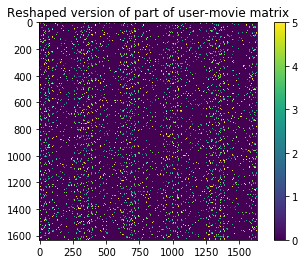

In [6]:
# creat users-movies matrix
users_movies=np.zeros((users_num,movies_num),dtype=int)
for row in train_ratings:
    m_index=movies_d[row[0]]
    u_index=users_d[row[1]]
    users_movies[u_index,m_index]=row[2]

# use the matrix and print rate given to the movie with id 28 by user with id 7
print("Usage example: Rate given to the movie with id 28 by user with id 7:",
      users_movies[users_d[7],movies_d[28]])

# let's print and plot some information about the users_movies matrix
print("Shape of the users_movies matrix: ", users_movies.shape)
zero_num=users_movies.size - np.count_nonzero(users_movies)
print("Number of zero element of the matrix: ", zero_num)
print("Sparsness of the matrix: ", (math.floor(float(zero_num) / users_movies.size*100)), "%")

# reshape and plot part of the matrix like an image to get a sense of sparsity of the matrix
plot_flag = True
if plot_flag == True:
    plt.imshow(users_movies.reshape(1632,1633))
    plt.colorbar()
    plt.title("Reshaped version of part of user-movie matrix")
    plt.show()
        

# Find the average ratings given by each user

If you look at the first equation in the [reference paper](#reference) section 2.1 you can see that we need to find mean vote (rating) of each user, so let's measure that first. Keep in mind that we should only consider those movies (or items) that the user has given a vote for it (so we cannot simple use the np.mean() here)

In [7]:
# mesaure vote average for each user
users_sum_ratings = np.sum(users_movies, axis=1, keepdims=True, dtype=float)
nonzero_nums= np.count_nonzero(users_movies, axis=1).reshape(users_sum_ratings.shape)
users_avg_ratings = users_sum_ratings / nonzero_nums


print("Number of users with zero average ratings: " , users_avg_ratings.size - np.count_nonzero(users_avg_ratings))
# print some of the values
s, e=0, 10
print("users_sum_ratings from "+str(s)+" to "+str(e)+": ", users_sum_ratings[s:e])
print("nonzero_nums from "+str(s)+" to "+str(e)+": ",nonzero_nums[s:e])
print("users_avg_ratings from "+str(s)+" to "+str(e)+": ",users_avg_ratings[s:e])

('Number of users with zero average ratings: ', 0)
('users_sum_ratings from 0 to 10: ', array([[20.],
       [29.],
       [15.],
       [20.],
       [18.],
       [11.],
       [30.],
       [36.],
       [12.],
       [31.]]))
('nonzero_nums from 0 to 10: ', array([[ 6],
       [ 8],
       [ 4],
       [ 5],
       [ 6],
       [ 3],
       [ 9],
       [15],
       [ 4],
       [ 7]]))
('users_avg_ratings from 0 to 10: ', array([[3.33333333],
       [3.625     ],
       [3.75      ],
       [4.        ],
       [3.        ],
       [3.66666667],
       [3.33333333],
       [2.4       ],
       [3.        ],
       [4.42857143]]))


# Normalize user votes

By looking at the equations 1 and 2 in the [reference paper](#reference) you can see that we always be using the normalized votes, so let's normalized them before hand. Normalization here means just subtracting average vote of each user from all the rates given by that user.

In [8]:
# Normalize rates by the users average weight

non_zero_mask= np.zeros(users_movies.shape, dtype=int)
non_zero_mask[users_movies>0]=1 # elements of this matrix are 1 wherever is a non zero value in the users_movies

users_movies_normalized = np.subtract(users_movies,users_avg_ratings)
# we should do subtraction just for movies that already are rated, 
#    so we make the others zero by this multiplication
users_movies_normalized = np.multiply(users_movies_normalized,non_zero_mask)

# see some numbers
print ("users_movies for first user: ", users_movies[0,:])
print("averate vote of the first user: ", users_avg_ratings[0])
print ("users_movies_normalized for first user: ", users_movies_normalized[0,:])

('users_movies for first user: ', array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0]))
('averate vote of the first user: ', array([3.33333333]))
('users_movies_normalized for first user: ', array([ 0.66666667, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.66666667, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.33333333,
       -0.33333333, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , 

# Common movies between users

In this point, I want to store the number of common movies rated by every pair of users. For example, how many movies are rated by both first and second user?! 

I don't want to write a `foor-loop` to do that. From previous step, we have the `non_zero_mask` matrix in which if a user has voted for a movie (whatever the exact value of vote might be) the corresponding element in this matrix is 1 and 0 otherwise. By multiplying this matrix in its transpose, we can indirectly (and efficiently) count the number of common movies between all pairs of users.

This is the most time consuming part of the code. It may take up to 3 minutes!

In [9]:
# form a matrix containing the number of common movies between users
common_matrix=np.matmul(non_zero_mask , non_zero_mask.T)

In [10]:
def predict_rating(user_index, movie_index, min_common_threshold=2):
    """
    Predicts the possible rating by a user with index 'user_index' to a movie with index 'movie_index' in the dataset.
    Note: user_index, movie_index are not user id and movie id, they are converted to index in the matrix before passing to this function.
    
    Arguments:
    user_index -- index of the user in the dataset (For example user 0 (this index corresponds with user id 7))
    movie_index -- index of the movie in the dataset
    min_common_threshold -- minimum number of common movies voted by a pair of users to consider them as similar
    
    Returns:
    predicted_rate -- float number between 0 and 5 
    
    """
    # find those users in that have common movies with the query user more than min_common_threshold 
    common_row = common_matrix [user_index,:]
    similar_users= (np.where( common_row > min_common_threshold))[0] # The function np.Where() returns results in the form of tuple, we need the
                                                      #  list of indexes which in in the first lement of that tuple
    
    active_user_ratings = users_movies_normalized [user_index,:] #these are normalized ratings, no need to subtract average
    
    number_of_similar_users = similar_users.size
    similarity_list = np.zeros((number_of_similar_users,1), dtype=float) # Empty list to store similarity measures (all w(a,i) from equation (2))
    
    if (number_of_similar_users == 0):
        print ('No smilar user in the dataset found! ')
        print ('Averge rating for the user is returned! ')
        predicted_rate = users_avg_ratings[user_index]
        return predicted_rate
    
   
    for i in range(number_of_similar_users):
        current_similar_user_index = similar_users [i]
        current_similar_user_ratings = users_movies_normalized [current_similar_user_index,:]

        # Numinator of the equation (2): sum of product of active users normalized rating with all similar users
        numinator= np.matmul(active_user_ratings.T , current_similar_user_ratings)
        
        # Denominator part: To avoid foor loops I will using logical operations
        number_of_movies = active_user_ratings.size
        denuminator_1 = 0
        denuminator_2 = 0

        for j in range(number_of_movies):
            if active_user_ratings[j] !=0 and current_similar_user_ratings[j] !=0:
                denuminator_1 += (active_user_ratings[j] **2)
                denuminator_2 += (current_similar_user_ratings[j] **2)
        denuminator = math.sqrt(denuminator_1 * denuminator_2)

        # Avoid division
        if denuminator == 0:
            similarity_list[i] = 0
        else:
            similarity_list[i] = numinator / denuminator      
        
    # Finally sum up every thing and mesure predicted rate
    sigma_part = 0
    for i in range(number_of_similar_users):
        current_similar_user_index = similar_users [i]
        sigma_part = users_movies_normalized [current_similar_user_index, movie_index] * similarity_list[i]
    
    
    normalization_factor = np.sum(np.absolute(similarity_list))
    predicted_rate= users_avg_ratings[user_index]
    
    if normalization_factor !=0:
        predicted_rate +=  sigma_part / normalization_factor
        
    # Finall sanity checks (This will not happen hopefully)
    if predicted_rate > 5: 
        predicted_rate = 5 
    elif predicted_rate < 0:
        predicted_rate = 0
    
    return predicted_rate

# Test it

Now lets the method on test data that we already now the real votes. One simple measure of the quality of the method would mean squared error.

Change test_samples_num to run it for more test examples.

In [11]:
# test the method on test data and report the error
error = 0
test_samples_num = 10 # or test_ratings.shape[0] for all test samples
for r in range(test_samples_num):

    row = test_ratings[r,:]
    movie_id = row[0]
    test_user_id = row[1]
    movie_index = movies_d[movie_id]
    test_user_index = users_d[test_user_id]
    real_rate=row[2]
    
    predicted_rate = predict_rating(test_user_index, movie_index, min_common_threshold =1)
    predicted_rate = np.squeeze(predicted_rate) # convert [2.30] to 2.30
    predicted_rate = np.around(predicted_rate, decimals=2)
    
    print(100*"-")
    print("User with id: "+str(test_user_id)+ " to movie with id: "+str(movie_id))
    print("Predicted vote=" + str(predicted_rate))
    print("Real      vote="+ str(real_rate))
    error += (predicted_rate - real_rate) ** 2

print(100*"*")
print ('MSE: ', error / test_samples_num)

----------------------------------------------------------------------------------------------------
User with id: 422952.0 to movie with id: 13604.0
Predicted vote=3.8
Real      vote=4.0
----------------------------------------------------------------------------------------------------
User with id: 2442925.0 to movie with id: 1744.0
Predicted vote=4.0
Real      vote=4.0
----------------------------------------------------------------------------------------------------
User with id: 803610.0 to movie with id: 6482.0
Predicted vote=3.0
Real      vote=3.0
----------------------------------------------------------------------------------------------------
User with id: 740142.0 to movie with id: 3418.0
Predicted vote=4.2
Real      vote=3.0
----------------------------------------------------------------------------------------------------
User with id: 507921.0 to movie with id: 4544.0
Predicted vote=2.93
Real      vote=1.0
--------------------------------------------------------------

# Recommend some movie

We can use the algorithm to really recommend movies to a user. In this section we will ask for a user id and year, then we will recommend to that user movies that he/she may be interested in them. Recommended movies should be product of the quary year.

In [24]:
while True:
    
    quary_user_id = 160977 # default
    quary_year= '2004'

    quary_user_id =  int(input("Enter a valid user id (ex. 160977): "))
    quary_year = raw_input ("Enter the desired year (ex. 2004): ")

    # recommend the movie if the predicted rate is more than this
    min_rate_threshold = 1
    if quary_user_id in users_d:
        test_user_index = users_d[quary_user_id]
    else:
        print("User id not valid!")
        pass
    print (15*"*"+" Recommended movies "+15*"*")
    
    # loop over all movies in the dataset. test prediction for those that are produced in the quary year
    for m in movie_unique:
        movie_index = movies_d[m]
        if  users_movies[test_user_index, movie_index]==0 and movie_titles_dict[m][0] == quary_year:
            predicted_rate = predict_rating(test_user_index, movie_index, min_common_threshold=2)
            if predicted_rate >= min_rate_threshold:
                print(movie_titles_dict[m][1])
    print (40*"*")
    
    cmd = raw_input("Press q to exit or anything else to try again: ")
    print(cmd)
    if cmd == "q":
        break

Enter a valid user id (ex. 160977): 160977
Enter the desired year (ex. 2004): 2004
*************** Recommended movies ***************
Spider-Man vs. Doc Ock
Schizo
LeapFrog: Math Circus
Dario Argento's The Card Player
ABC News Presents: Jesus
The Ranch
DiG!
The Murder Room
Witness to a Kill
Farscape: The Peacekeeper Wars: Bonus Material
13 Going on 30
****************************************
Press q to exit or anything else to try again: q
q


# Reference

<a id="reference"> </a>
[1] [Empirical analysis of Predictive Algorithms for Collaborative Filtering by John S. Breese et al. 1998](https://arxiv.org/pdf/1301.7363.pdf)